# Project 3


# Conversations Toxicity Detection

Jigsaw Unintended Bias in Toxicity Classification 

Detect toxicity across a diverse range of conversations


https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data#

# Sample Solution

### Install the Kaggle API and download the datasets

## Model with TF-IDF and Ranfom Forest

In [1]:
import pandas as pd
import numpy as np

from keras.preprocessing import text, sequence
from keras import backend as K
from keras.models import load_model
import keras
import pickle

import string
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
%matplotlib inline

Using TensorFlow backend.


In [2]:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
stop_words = set(stopwords.words('english'))
stem = SnowballStemmer('english')

In [3]:
train_df = pd.read_csv("../input/train.csv")
train_df = train_df[['id','comment_text', 'target']]
test_df = pd.read_csv("../input/test.csv")

In [4]:
train_df.head()

,id,comment_text,target
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000
1,59849,Thank you!! This would make my life a lot less...,0.000000
2,59852,This is such an urgent design problem; kudos t...,0.000000
3,59855,Is this something I'll be able to install on m...,0.000000
4,59856,haha you guys are a bunch of losers.,0.893617


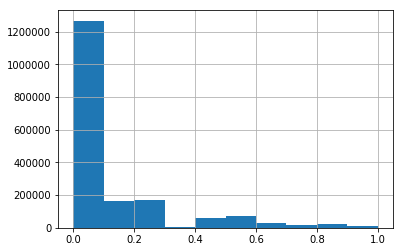

In [5]:
train_df.target.hist()

In [6]:
train_df.shape

(1804874, 3)

In [7]:
test_df.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [8]:
test_df.shape

(97320, 2)

### Análisis duplicidad comentarios

In [9]:
total_num_comments = train_df.shape[0]
unique_comments = train_df['comment_text'].nunique()

print('Train set: %d (Entries) and %d (Attributes).' % (train_df.shape[0], train_df.shape[1]))
print('Test set: %d (Entries) and %d (Attributes).' % (test_df.shape[0], test_df.shape[1]))

print('Number of Unique Comments {}'.format(unique_comments))
print('Percentage of Unique Comments %.2f%%' %( (unique_comments/total_num_comments)*100 ))

Train set: 1804874 (Entries) and 3 (Attributes).
Test set: 97320 (Entries) and 2 (Attributes).
Number of Unique Comments 1780823
Percentage of Unique Comments 98.67%


### Clasificación inicial de comentarios en Tóxicos y NO Tóxicos

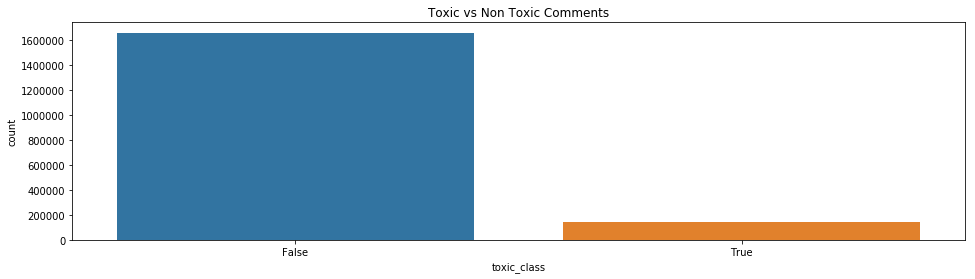

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
train_df['toxic_class'] = train_df['target'] >= 0.5
plt.figure(figsize=(16,4))
sns.countplot(train_df['toxic_class'])
plt.title('Toxic vs Non Toxic Comments')
plt.show()

## Procesamiento

In [11]:
train_data = train_df["comment_text"]
label_data = train_df["target"]
test_data = test_df["comment_text"]
train_data.shape, label_data.shape, test_data.shape

((1804874,), (1804874,), (97320,))

In [12]:
def tokenize(text):
    
    tokens = []
    for token in word_tokenize(text):
        if token in string.punctuation: continue
        if token in stop_words: continue
        tokens.append(stem.stem(token))
    
    return " ".join(tokens)

In [13]:
train_tokens = Parallel(n_jobs=-1, verbose=1)(delayed(tokenize)(text) for text in train_data.tolist())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1319 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 13319 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 33319 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 61319 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 97319 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 141319 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 193319 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 253319 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 321319 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 397319 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 481319 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 573319 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 673319 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 781319 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)

In [14]:
train_tokens[0]

"this cool it 's like would want mother read realli great idea well done"

In [15]:
test_tokens = Parallel(n_jobs=-1, verbose=1)(delayed(tokenize)(text) for text in test_data.tolist())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 6540 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 31740 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 73740 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 97320 out of 97320 | elapsed:  1.7min finished


In [16]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(train_tokens) + list(test_tokens))

In [17]:
train_data = tokenizer.texts_to_sequences(train_tokens)
test_data = tokenizer.texts_to_sequences(test_tokens)

In [18]:
MAX_LEN = 200
train_data = sequence.pad_sequences(train_data, maxlen=MAX_LEN)
test_data = sequence.pad_sequences(test_data, maxlen=MAX_LEN)

In [19]:
max_features = None
max_features = max_features or len(tokenizer.word_index) + 1
max_features

283065

In [20]:
type(train_data), type(label_data.values), type(test_data)
label_data = label_data.values

In [21]:
# Keras Model
# Model Parameters
NUM_HIDDEN = 512
EMB_SIZE = 256
LABEL_SIZE = 1
MAX_FEATURES = max_features
DROP_OUT_RATE = 0.25
DENSE_ACTIVATION = "sigmoid"
NUM_EPOCHS = 1

# Optimization Parameters
BATCH_SIZE = 1024
LOSS_FUNC = "binary_crossentropy"
OPTIMIZER_FUNC = "adam"
METRICS = ["accuracy"]

In [22]:
class LSTMModel:
    
    def __init__(self):
        self.model = self.build_graph()
        self.compile_model()
    
    def build_graph(self):
        model = keras.models.Sequential([
            keras.layers.Embedding(MAX_FEATURES, EMB_SIZE),
            keras.layers.CuDNNLSTM(NUM_HIDDEN),
            keras.layers.Dropout(rate=DROP_OUT_RATE),
            keras.layers.Dense(LABEL_SIZE, activation=DENSE_ACTIVATION)])
        return model
    
    def compile_model(self):
        self.model.compile(
            loss=LOSS_FUNC,
            optimizer=OPTIMIZER_FUNC,
            metrics=METRICS)

In [23]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gc
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
import numpy as np

X_train = train_data
y_train = label_data
X_test = test_data

KFold_N = 3
splits = list( KFold(n_splits=KFold_N).split(X_train,y_train) )

oof_preds = np.zeros((X_train.shape[0]))
test_preds = np.zeros((X_test.shape[0]))

In [24]:
for fold in range(KFold_N):
    K.clear_session()
    tr_ind, val_ind = splits[fold]
    ckpt = ModelCheckpoint(f'gru_{fold}.hdf5', save_best_only = True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    model = LSTMModel().model#build_model()
    model.fit(X_train[tr_ind],
        y_train[tr_ind]>0.5,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        validation_data=(X_train[val_ind], y_train[val_ind]>0.5),
        callbacks = [es,ckpt])

    oof_preds[val_ind] += model.predict(X_train[val_ind])[:,0]
    test_preds += model.predict(X_test)[:,0]
    
test_preds /= KFold_N    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1203249 samples, validate on 601625 samples
Epoch 1/1
1203249/1203249 [==============================] - 471s 392us/step - loss: 0.1150 - acc: 0.9591 - val_loss: 0.0990 - val_acc: 0.9625
Train on 1203249 samples, validate on 601625 samples
Epoch 1/1
1203249/1203249 [==============================] - 475s 394us/step - loss: 0.1217 - acc: 0.9568 - val_loss: 0.0965 - val_acc: 0.9637
Train on 1203250 samples, validate on 601624 samples
Epoch 1/1
1203250/1203250 [==============================] - 468s 389us/step - loss: 0.1160 - acc: 0.9594 - val_loss: 0.1077 - val_acc: 0.9594


In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train>=0.5,oof_preds)

0.9454301240641293

In [26]:
submission_df = pd.read_csv('../input/sample_submission.csv', index_col='id') 
submission_df['prediction'] = test_preds 
submission_df.reset_index(drop=False, inplace=True) 
submission_df.head()

,id,prediction
0,7000000,0.002029
1,7000001,0.001235
2,7000002,0.006086
3,7000003,0.000891
4,7000004,0.918076


In [28]:
submission_df.to_csv('submission.csv', index=False)